# Analysis of full demolition permits by the City of Austin

In this notebook, we explore "construction" permits for demolitions of residential (single-family or duplex) homes.

- This analysis starts with a file that has been downloaded and processed in another notebook, `01_Download_Process.ipynb`.

## Set up and configurations

In [1]:
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 60

## Import file
Imports the file that was processed in another notebook.

In [2]:
# Column data type fixes
column_types = {
    'ApplicantPhone': pd.np.str,
    'ContractorPhone': pd.np.str,
    'CalendarYearIssued': pd.np.str,
    'OriginalZip': pd.np.str,
}

# import raw data
data_raw = pd.read_csv(
    '../data-processed/demolitions_full.csv',
    index_col=None,
    dtype=column_types,
    parse_dates=['IssuedDate']
)

demolitions = data_raw

demolitions.shape

(3160, 68)

## Total cases

In [3]:
print('Number of full demolitions from Jan. 2008 to July 2018 be additions:\n\n{}'.format(len(demolitions)))


Number of full demolitions from Jan. 2008 to July 2018 be additions:

3160


## How the number of demolition permits have changed over time

How many demolition permits have been been issued in past years?

### Permits per year

In [4]:
# create dataframe from pivot of permits per year
demos_by_year = demolitions.CalendarYearIssued.value_counts().reset_index()
demos_by_year.columns = ['Year', 'Count']
demos_by_year.sort_values('Year')

,Year,Count
10,2008,110
9,2009,137
8,2010,152
7,2011,176
6,2012,263
4,2013,328
2,2014,357
3,2015,347
1,2016,445
0,2017,565


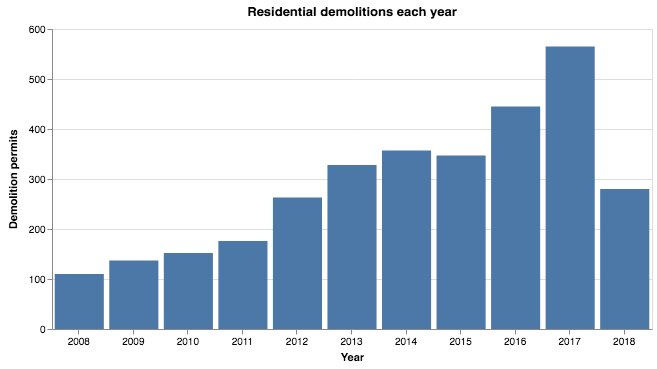

In [5]:
# Chart based on dataframe above
alt.Chart(
    demos_by_year.reset_index(),
    title="Residential demolitions each year"
).mark_bar().encode(
    x=alt.X("Year:O", axis=alt.Axis(title="Year", labelAngle=0)),
    y=alt.Y("Count:Q", axis=alt.Axis(title="Demolition permits")),
).properties(width=600)

### Permits in first half of year

If we want to see the pace of demolition permits in 2018, we need to look at the first six months of each year and compare them.

In [6]:
# Filter demolitions to only those before July in any given year
six_months_filtered = demolitions[demolitions.IssuedDate.dt.month < 7]
six_months_filtered.shape

(1658, 68)

In [7]:
# make dataframe based on pivot of permits per year
six_months_data = six_months_filtered.CalendarYearIssued.value_counts().reset_index()
six_months_data.columns = ['Year', 'Count']
six_months_data

,Year,Count
0,2017,306
1,2018,280
2,2014,176
3,2013,167
4,2016,159
5,2015,150
6,2012,132
7,2011,84
8,2010,75
9,2009,68


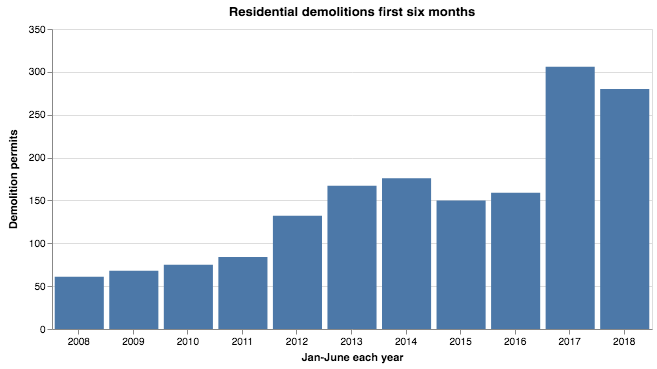

In [8]:
# Build chart based on dataframe above
alt.Chart(
    six_months_data.reset_index(),
    title="Residential demolitions first six months"
).mark_bar().encode(
    x=alt.X("Year:O", axis=alt.Axis(title="Jan-June each year", labelAngle=0)),
    y=alt.Y("Count:Q", axis=alt.Axis(title="Demolition permits")),
).properties(width=600)

## Square footage of residential homes demolished

A look in case there is some change in the type or style of homes being demolished.

In [9]:
demos_spft = demolitions.groupby('CalendarYearIssued').sum().TotalExistingBldgSQFT.reset_index()
demos_spft.columns = ['Year', 'SqFt']
demos_spft

,Year,SqFt
0,2008,131987.0
1,2009,172399.0
2,2010,197725.0
3,2011,245702.0
4,2012,339043.0
5,2013,294329.0
6,2014,425708.0
7,2015,362767.0
8,2016,654906.0
9,2017,843899.0


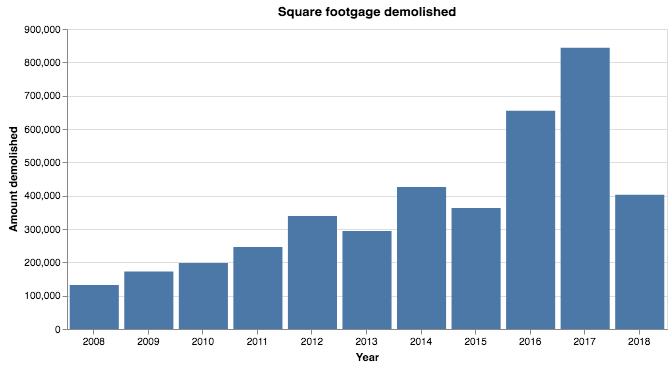

In [10]:
alt.Chart(demos_spft.reset_index(), title="Square footgage demolished").mark_bar().encode(
    x=alt.X("Year:O", axis=alt.Axis(title="Year", labelAngle=0)),
    y=alt.Y("SqFt:Q", axis=alt.Axis(title="Amount demolished")),
).properties(width=600)

The total square footage pretty much tracks with the number of permits, and isn't very revealing.

### Pace by square footage first half of year
It looks like the pace for 2018, is a bit less than 2017.

In [11]:
# group by year, sqft totals for first six months
demos_spft_6mo = six_months_filtered.groupby(
    'CalendarYearIssued'
).sum().TotalExistingBldgSQFT.reset_index()
demos_spft_6mo.columns = ['Year', 'SqFt']
demos_spft_6mo

,Year,SqFt
0,2008,78621.0
1,2009,74045.0
2,2010,95895.0
3,2011,126032.0
4,2012,180176.0
5,2013,87939.0
6,2014,207848.0
7,2015,159388.0
8,2016,201239.0
9,2017,505389.0


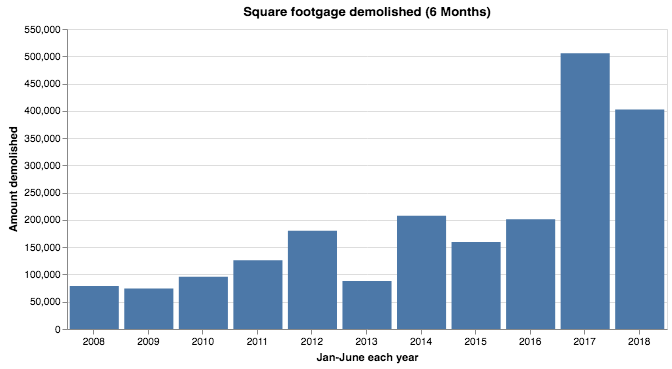

In [12]:
# chart based on dataframe above
alt.Chart(
    demos_spft_6mo.reset_index(),
    title="Square footgage demolished (6 Months)"
).mark_bar().encode(
    x=alt.X("Year:O", axis=alt.Axis(title="Jan-June each year", labelAngle=0)),
    y=alt.Y("SqFt:Q", axis=alt.Axis(title="Amount demolished")),
).properties(width=600)

### Average square feet by year

In [13]:
# group by year, sqft totals for first six months
demos_spft_avg = demolitions.groupby(
    'CalendarYearIssued'
).mean().TotalExistingBldgSQFT.reset_index()
demos_spft_avg.columns = ['Year', 'Avg SqFt']
demos_spft_avg

,Year,Avg SqFt
0,2008,1199.881818
1,2009,1258.386861
2,2010,1300.822368
3,2011,1396.034091
4,2012,1289.136882
5,2013,897.344512
6,2014,1192.459384
7,2015,1045.438040
8,2016,1471.698876
9,2017,1493.626549


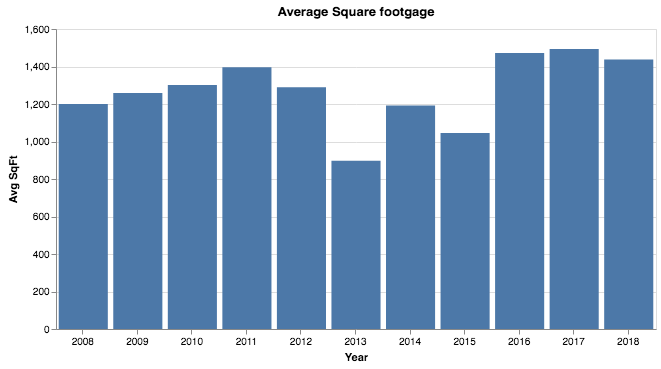

In [14]:
# chart based on dataframe above
alt.Chart(
    demos_spft_avg.reset_index(),
    title="Average Square footgage"
).mark_bar().encode(
    x=alt.X("Year:O", axis=alt.Axis(title="Year", labelAngle=0)),
    y=alt.Y("Avg SqFt:Q", axis=alt.Axis(title="Avg SqFt")),
).properties(width=600)

Also not particularly revealing.

### Distribution of square footage

To get an idea on the sizes of homes that are demolished. This chart could use some more work to show how the bins are defined. It's offering few insights as-is.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111c0c748>]],
      dtype=object)

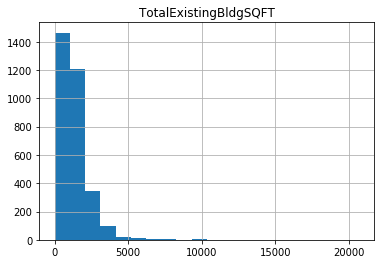

In [15]:
demolitions.hist(column='TotalExistingBldgSQFT', bins=20)

## Demolitions by ZIP code

ZIP code is probably the most recognizable geographic reference we have in the data, and allows us to see the pace of demolitions differs throughout the city. 

In [16]:
# make a dataframe with counts of permits by zip code
demos_by_zip = demolitions.OriginalZip.value_counts().reset_index()
demos_by_zip.columns = ['Zip', 'Count']
# peek at result
demos_by_zip.head()

,Zip,Count
0,78704,624
1,78702,551
2,78703,371
3,78757,215
4,78731,174


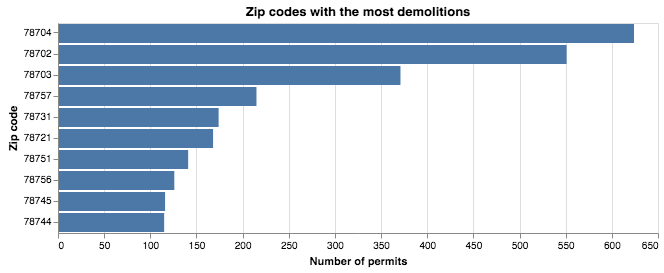

In [17]:
# chart based on first ten items in dataframe above
alt.Chart(
    demos_by_zip.head(10),
    title="Zip codes with the most demolitions"
).mark_bar().encode(
    x=alt.X("Count:Q",
            axis=alt.Axis(title="Number of permits")),
    y=alt.Y("Zip:O",
            # this is the sorting magic
            sort=alt.SortField(
                field="Count",
                order="descending",
                op="sum"
            ),
            axis=alt.Axis(title="Zip code")),
).properties(width=600)

## Demolitions by zip code and year

How is the pace of demolitions changing in different parts of the city? Again, we look at ZIP codes for insight.

#### Build our dataframe

In [18]:
# this is all years, then grouped by year, zip and count
demos_yr_zip_all = demolitions.groupby(['CalendarYearIssued','OriginalZip']).agg(dict(
    PermitNum='count'
)).reset_index()
demos_yr_zip_all.columns = ['Year', 'Zip', 'Count']
demos_yr_zip_all.shape

(284, 3)

In [19]:
# Filter out 2018 because it is a partial year
before_2018 = demolitions[demolitions['CalendarYearIssued'] != '2018']

# build a dataframe of yr, zip, count
demos_yr_zip = before_2018.groupby(['CalendarYearIssued','OriginalZip']).agg(dict(
    PermitNum='count'
)).reset_index()
demos_yr_zip.columns = ['Year', 'Zip', 'Count']
demos_yr_zip.shape

(260, 3)

In [20]:
# peek at it
demos_yr_zip.head()

,Year,Zip,Count
0,2008,78702,18
1,2008,78703,22
2,2008,78704,24
3,2008,78705,2
4,2008,78721,7


#### All Zips over time

Just to see the mess of all demos to see their distribution, of sorts.

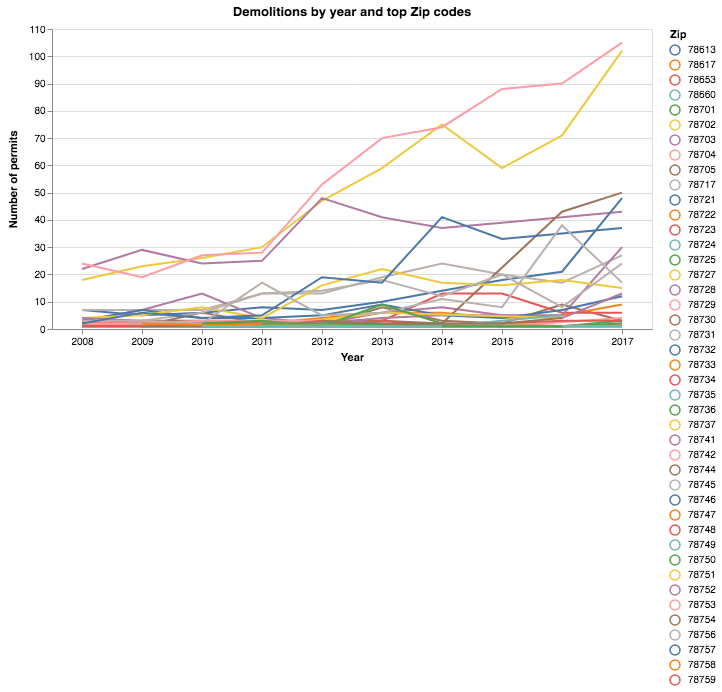

In [21]:
alt.Chart(demos_yr_zip, title="Demolitions by year and top Zip codes").mark_line().encode(
    x=alt.X("Year:O",
            axis=alt.Axis(title="Year", labelAngle=0)),
    y=alt.Y("Count:Q",
            axis=alt.Axis(title="Number of permits")),
    color="Zip"
).properties(width=600)

#### A look at top picks zips

Filtering to zip codes that that had more than 15 demos in 2017.

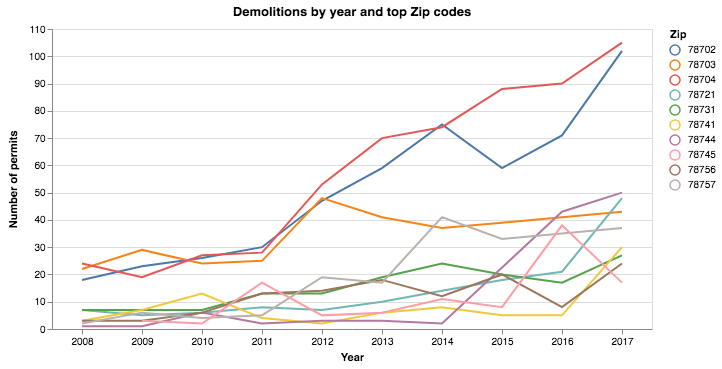

In [22]:
# filter our zip/year datafram to just 2017
zips_2017 = demos_yr_zip[demos_yr_zip['Year'] == '2017']

# filter the 2017 list to zips with 10+ demos
# sort the list by count descending
zips_2017_top = zips_2017[zips_2017.Count > 15].sort_values(
    'Count',
    ascending=False
)

# Use the Zip code column above to filter the original demos_yr_zip datatable
# and create the new dataframe to chart
top_demos_yr_zip = demos_yr_zip[demos_yr_zip['Zip'].isin(zips_2017_top.Zip)]

# draw chart based on above dataframe
alt.Chart(
    top_demos_yr_zip,
    title="Demolitions by year and top Zip codes"
).mark_line().encode(
    x=alt.X("Year:O",
            axis=alt.Axis(title="Year", labelAngle=0)),
    y=alt.Y("Count:Q",
            axis=alt.Axis(title="Number of permits")),
    color="Zip"
).properties(width=600)

## A look at specific zip codes

### What's up with 78744, and is 2015 missing?

Noticing the increase in demolitions in 78744 in the graphic above, let's look a little deeper into them. It looks like the 2016 and 2017 increases are flood buyouts.

In [23]:
# show how many in each year
zip_78744 = demos_yr_zip_all[demos_yr_zip_all['Zip'] == '78744']
zip_78744

,Year,Zip,Count
11,2008,78744,1
33,2009,78744,1
59,2010,78744,6
84,2011,78744,2
113,2012,78744,3
137,2013,78744,3
163,2014,78744,2
218,2016,78744,43
248,2017,78744,50
274,2018,78744,4


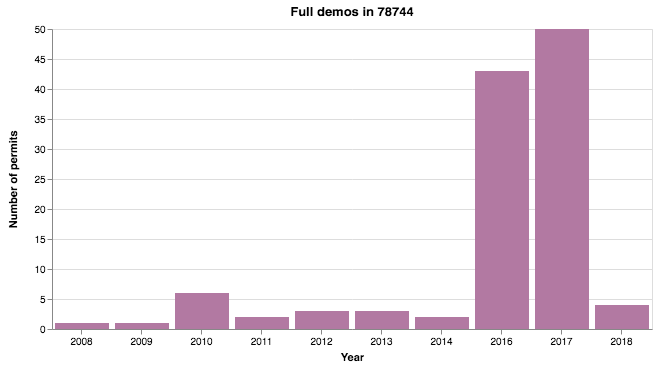

In [24]:
alt.Chart(zip_78744.reset_index(), title="Full demos in 78744").mark_bar(color='#b279a2').encode(
    x=alt.X("Year:O", axis=alt.Axis(title="Year", labelAngle=0)),
    y=alt.Y("Count:Q", axis=alt.Axis(title="Number of permits")),
).properties(width=600)
# rosybrown

In [25]:
# look at the descriptions of these homes
pd.options.display.max_colwidth = 80
permits_78744 = demolitions[demolitions['OriginalZip'] == '78744']
permits_78744[['CalendarYearIssued', 'Description']].head(30)

,CalendarYearIssued,Description
92,2018,total demo of sf res flood mitigation
93,2018,total demo of sf res flood mitigation
150,2018,total demo of sf res 1978 flood mitigation
181,2018,Total demolition of existing sf res
316,2017,Total demolition of existing SFR City of Austin Flood BuyOut
371,2017,Total demolition of existing duplex residence Built circa 1973
463,2017,total demo of sf res
526,2017,Total demolition of existing SFR City of Austin Flood BuyOut
527,2017,Total demolition of existing SFR City of Austin Flood BuyOut
543,2017,Total demolition of existing SFR City of Austin Flood BuyOut


### Is 78741 the new demo target?

There was a big increase in 2017, so what's up with that? 2018 is not keeping pace. There were eight on the same piece of property, which is part of the increase, but others are more spread out.

In [26]:
# show how many in each year
zip_78741 = demos_yr_zip_all[demos_yr_zip_all['Zip'] == '78741']
zip_78741

,Year,Zip,Count
10,2008,78741,3
31,2009,78741,7
57,2010,78741,13
83,2011,78741,4
111,2012,78741,2
136,2013,78741,6
161,2014,78741,8
188,2015,78741,5
216,2016,78741,5
246,2017,78741,30


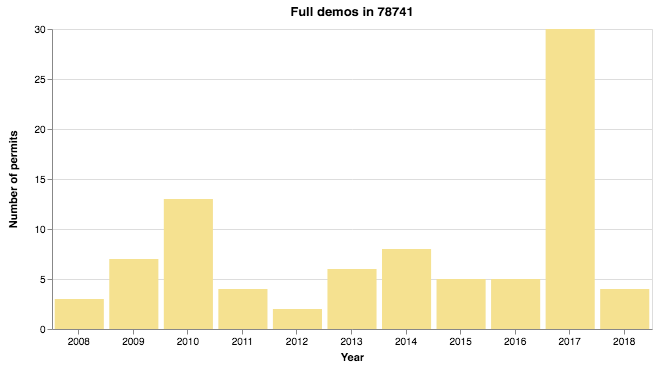

In [27]:
alt.Chart(zip_78741.reset_index(), title="Full demos in 78741").mark_bar(color='#f5e190').encode(
    x=alt.X("Year:O", axis=alt.Axis(title="Year", labelAngle=0)),
    y=alt.Y("Count:Q", axis=alt.Axis(title="Number of permits")),
).properties(width=600)

In [28]:
pd.options.display.max_colwidth = 60
# look at the descriptions of these homes
permits_78741 = demolitions[demolitions['OriginalZip'] == '78741']

# filter to 2017 to look at descriptions
permits_78741_2017 = permits_78741[permits_78741['CalendarYearIssued'] == '2017']
permits_78741_2017[['ProjectName', 'Description', 'ContractorCompanyName']].head(30)

,ProjectName,Description,ContractorCompanyName
283,919 VALDEZ ST,total demo home circa 1942,Precise Custom Homes Inc***MAIN***
287,904 VASQUEZ ST,total demo of house,Austin Triangle LLC
324,2006 MAXWELL LN,total demo of sf res 1950,NaN
330,6709 PONCA ST,total demo of home circa 1997,DAR Construction
337,500 BASTROP HWY SB,total demo of sf res circa 1957 2417 sq ft,DAR Construction
338,500 BASTROP HWY SB,total demo of sf res circa 1958 780 sq ft,DAR Construction
348,508 THRASHER LN,total demo of house circa 1945,DAR Construction
349,7409 E RIVERSIDE DR,total demo of sf res circa 1955,DAR Construction
350,7405 E RIVERSIDE DR,total demo of home circa 1954,DAR Construction
351,436 BASTROP HWY SB,total demo of sf res 1542 sf,DAR Construction


### A look at 78731

78731 saw a noticable increase in 2017 and has almost as many in the first half of 2018.

The biggest changes are north of 45th, south of Hancock, east of MoPac, where there have been 60+ demolitions. There is a similar but smaller area east of Mopac between Perry Lane and Hancock.

In [29]:
# show how many in each year
zip_78731 = demos_yr_zip_all[demos_yr_zip_all['Zip'] == '78731']
zip_78731

,Year,Zip,Count
8,2008,78731,7
28,2009,78731,7
54,2010,78731,7
80,2011,78731,13
106,2012,78731,13
135,2013,78731,19
159,2014,78731,24
185,2015,78731,20
213,2016,78731,17
241,2017,78731,27


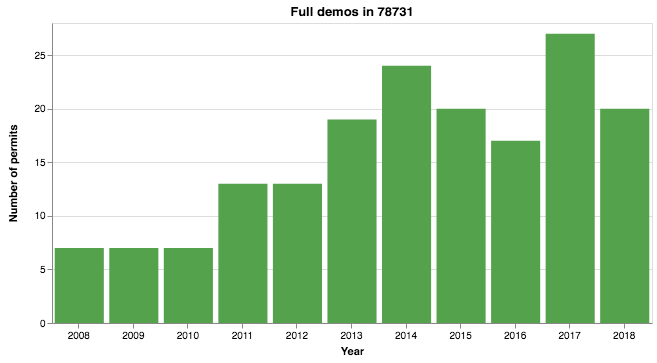

In [30]:
# chart based on dataframe above
alt.Chart(
    zip_78731.reset_index(),
    title="Full demos in 78731"
).mark_bar(color='#54a24b').encode(
    x=alt.X("Year:O", axis=alt.Axis(title="Year", labelAngle=0)),
    y=alt.Y("Count:Q", axis=alt.Axis(title="Number of permits")),
).properties(width=600)

### A look at 78721
This is the area south of MLK between Airport and Ed Bluestein. Demolitions more than doubled in 2017 and is on pace to hold steady there in 2018.

The area on and around PENNSYLVANIA AVE, GRANT ST, FRANKLIN AVE has a pretty heavy concentration of demolitions in 2017, but there are a ton of others around, to. In 2016, there was a strip on COMETA ST that was razed and replaced with a series of new duplexes.

I suspect but can't prove this is just the new hot spot for rebuilding/gentrification.

In [31]:
# show how many in each year
zip_78721 = demos_yr_zip_all[demos_yr_zip_all['Zip'] == '78721']
zip_78721

,Year,Zip,Count
4,2008,78721,7
24,2009,78721,5
51,2010,78721,6
76,2011,78721,8
101,2012,78721,7
128,2013,78721,10
154,2014,78721,14
181,2015,78721,18
206,2016,78721,21
237,2017,78721,48


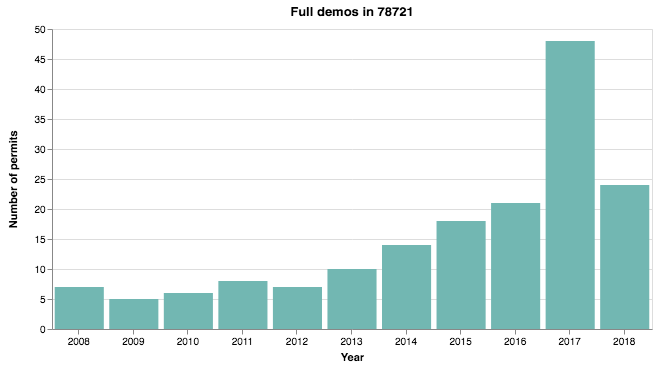

In [32]:
# chart based on dataframe above
alt.Chart(
    zip_78721.reset_index(),
    title="Full demos in 78721"
).mark_bar(color='#72b7b2').encode(
    x=alt.X("Year:O", axis=alt.Axis(title="Year", labelAngle=0)),
    y=alt.Y("Count:Q", axis=alt.Axis(title="Number of permits")),
).properties(width=600)


In [33]:
permits_78721_2017 = demolitions[
    (demolitions.OriginalZip == "78721")
    & (demolitions.CalendarYearIssued == "2017")
]
permits_78721_2017.OriginalAddress1

297       1142 BROOKSWOOD AVE
304              5005 ALF AVE
317            5005 HEFLIN LN
336       1153 WEBBERVILLE RD
341       1110 RICHARDINE AVE
344           1108 GARDNER CV
390           1104 SAUCEDO ST
405            1404 MARCUS PL
408        1101 SPRINGDALE RD
417           4908 LEDESMA RD
427     3501 PENNSYLVANIA AVE
430        4802 SANTA ANNA ST
431             1709 PEREZ ST
433            4704 LOUIS AVE
441     3413 PENNSYLVANIA AVE
442     3409 PENNSYLVANIA AVE
443     3602 PENNSYLVANIA AVE
444     3616 PENNSYLVANIA AVE
445             3601 GRANT ST
446             3607 GRANT ST
473           1102 SAUCEDO ST
501            1107 ESTES AVE
512          1706 OVERHILL DR
566              4601 ALF AVE
570            1300 COMETA ST
573           1142 ELEANOR ST
599            1125 EBERT AVE
615              4609 SARA DR
620        4706 SANTA ANNA ST
627            1130 MASON AVE
637            1119 WALTON LN
670             1412 PEREZ ST
675              1130 SPUR ST
698       

## Who is performing the demolitions?

The demolitions company is one who profits from this. Who does the most demolitions?

**NOTE:** This is just a rough look because the contractor names have not been cleaned. See the `02_Contractors` notebook for a more accurate look.

In [34]:
# top 10 by count 
demolitions.ContractorCompanyName.value_counts().head(10)

DAR Construction                        567
Southwest Destructors****MAIN***        227
Building Abatement Demolition Co Inc    101
AAR Inc.                                 83
MX3 Investments                          72
Absolute Demolition                      67
Heart of Texas Demolition, LLC           39
Pecan Valley Homes LLC***MAIN***         35
Paradisa Homes, LLC                      31
Gossett and Jones Homes Inc.             31
Name: ContractorCompanyName, dtype: int64

## Streets that have significant change

A dirty way to find some example streets that have changed alot. Idea is to strip block number and then count street name counts. Some of these are flooding buyouts.

In [35]:
# Create a dataframe of just street names by stripping off numbers
# get value counts
streets = demolitions.ProjectName.replace(
    {r'(\d+) (.*)' : r'\2'},
    regex=True
).value_counts().reset_index()

streets.columns = ['Street', 'Count']
streets.head(16)

,Street,Count
0,HASKELL ST,21
1,E 13TH ST,21
2,HEARTWOOD DR,18
3,WESTLAKE DR,17
4,S 3RD ST,17
5,HONEYBEE BND,17
6,E 3RD ST,16
7,SHOALWOOD AVE,16
8,ONION CREEK DR,16
9,PASADENA DR,16


## References
Ignore this. It's for column references.

In [36]:
demolitions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3160 entries, 0 to 3159
Data columns (total 68 columns):
Unnamed: 0                    3160 non-null int64
PermitType                    3160 non-null object
PermitTypeDesc                3160 non-null object
PermitNum                     3160 non-null object
PermitClassMapped             3160 non-null object
PermitClass                   3160 non-null object
WorkClass                     3160 non-null object
Condominium                   3160 non-null object
ProjectName                   3160 non-null object
Description                   3160 non-null object
TCAD_ID                       3146 non-null object
PropertyLegalDescription      2739 non-null object
AppliedDate                   3160 non-null object
IssuedDate                    3160 non-null datetime64[ns]
DayIssued                     3160 non-null object
CalendarYearIssued            3160 non-null object
FiscalYearIssued              3160 non-null int64
IssuedInLast30Days  